In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Dependencies**

In [ ]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

# **Paths and Directories**

In [ ]:
# Set up paths
base_path = '/content/drive/My Drive/Colab Notebooks/FacialRecognition'
POS_PATH = os.path.join(base_path, 'data', 'positive')
NEG_PATH = os.path.join(base_path, 'data', 'negative')
ANC_PATH = os.path.join(base_path, 'data', 'anchor')

In [ ]:
# Make the directories
os.makedirs(POS_PATH, exist_ok=True)
os.makedirs(NEG_PATH, exist_ok=True)
os.makedirs(ANC_PATH, exist_ok=True)

# **Collect Data**

## Negatives

In [ ]:
# Uncompress tar gz Labelled Faces in the Wild Dataset
dataset_path = '/content/drive/My Drive/Colab Notebooks/FacialRecognition/lfw.tgz'

# Uncompress into destination directory
destination_path = '/content/drive/My Drive/Colab Notebooks/FacialRecognition'
!tar -xf "{dataset_path}" -C "{destination_path}"

In [ ]:
lfw_path = os.path.join(base_path, 'lfw')

# these LFW images will servea s the negatives - move to negative directory
for directory in os.listdir(lfw_path):
    directory_path = os.path.join(lfw_path, directory)
    if os.path.isdir(directory_path):  # Check if it's a directory
        for file in os.listdir(directory_path):
            EX_PATH = os.path.join(directory_path, file)
            NEW_PATH = os.path.join(NEG_PATH, file)
            os.replace(EX_PATH, NEW_PATH)

## Positives and Anchors

In [ ]:
#run on a local notebook for easier webcam access

import uuid #for unique names

#connect to webcam
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()

    #crop frame to (250,250,) from (480,640,)
    frame = frame[110:110+250,200:200+250, :]

    # display frame
    cv2.imshow('Image Collection', frame)

    # press 'a' to record anchor image
    if cv2.waitKey(1) & 0XFF == ord('a'):
        #create unique filepath for image
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        #write image to anchor using its unique name
        cv2.imwrite(imgname, frame)

    # pres 'p' to record positive image
    if cv2.waitKey(1) & 0XFF == ord('p'):
        #create unique filepath for image
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        #write image to positive using its unique name
        cv2.imwrite(imgname, frame)

    #close window
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

#release webcam
cap.release()
cv2.destroyAllWindows()

# **Load then preprocess images**

## Load data

In [ ]:
#take 500 of each

anchor = tf.data.Dataset.list_files(os.path.join(ANC_PATH, '*.jpg')).take(500)
positive = tf.data.Dataset.list_files(os.path.join(POS_PATH, '*.jpg')).take(500)
negative = tf.data.Dataset.list_files(os.path.join(NEG_PATH, '*.jpg')).take(500)

## Function to resize image and scale pixels from 0-255 to 0-1

In [ ]:
#funciton takes in the file path, returns the resized and scaled image array

def preprocess(file_path):

    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image
    img = tf.io.decode_jpeg(byte_img)

    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1
    img = img / 255.0

    # Return image
    return img

## Label dataset and apply preprocess function

In [ ]:
# lists of (anchor,pos/neg,1/0)
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))

data = positives.concatenate(negatives)

In [ ]:
#apply preprocess function to all iamges in data

def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

## Train-test partition

In [ ]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()

#shuffle so positives and negatives are mixed
data = data.shuffle(buffer_size=10000)

In [ ]:
#use 70-30 train-test split, using batch size of 16

# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# **Model**

## Embedding Layer

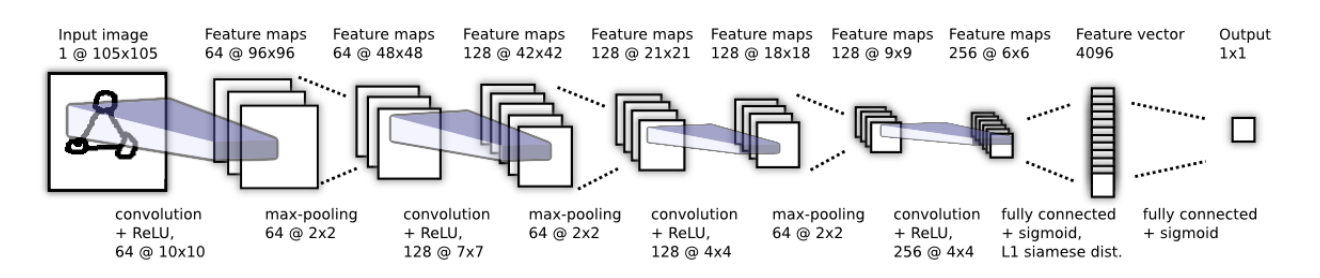

In [ ]:
from IPython.display import Image, display
image_path = "/content/drive/MyDrive/Colab Notebooks/FacialRecognition/Embedding.png"
display(Image(filename=image_path))

In [ ]:
def make_embedding():

    inp = Input(shape=(100,100,3), name='input_image')

    # block 1
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    # block 2
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    # block 3
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    # block 4
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f = Flatten()(c4)
    d = Dense(4096, activation='sigmoid')(f)


    return Model(inputs=[inp], outputs=d, name='embedding')

In [ ]:
embedding = make_embedding()

In [ ]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

## Distance Layer

In [ ]:
# Siamese L1 distnace class

class L1Dist(Layer):

    def __init__(self, **kwargs):
        super().__init__()

    # similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

## Make the Siamese model

In [ ]:
def make_siamese_model():

    # anchor img input
    input_image = Input(name='input_img', shape=(100,100,3))

    # validation img input (pos/neg)
    validation_image = Input(name='validation_img', shape=(100,100,3))

    # create distance layer
    siamese_layer = L1Dist()
    # call distance layer for similarity calculation
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # classification
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [ ]:
siamese_model = make_siamese_model()

In [ ]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)    │ (None, 100, 100, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ validation_img            │ (None, 100, 100, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Functional)    │ (None, 4096)           │     38,960,448 │ input_img[0][0],       │
│                           │                        │                │ validation_img[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l1_dist_4 (L1Dist)        │ (None, 4096)           │              0 │ embedding[8][0],       │
│                           │                        │                │ embedding[9][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 1)              │          4,097 │ l1_dist_4[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# **Training**

## Loss and optimzer

In [ ]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4)

## Checkpoints

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## Train step

In [ ]:
#training for one batch

@tf.function
def train_step(batch):

    with tf.GradientTape() as tape:

        # anc, pos/neg images
        X = batch[:2]

        # true labels
        y = batch[2]

        # forward pass
        ypred = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, ypred)

    # gradient calculations
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # calculate updated parameters, apply to model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    return loss

## Train loop

In [ ]:
#metrics
from tensorflow.keras.metrics import Precision, Recall, Accuracy

In [ ]:
def train(data, EPOCHS):

    for epoch in range(1, EPOCHS+1):

        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        # metric objects
        r = Recall()
        p = Precision()

        # train_step on each batch
        for idx, batch in enumerate(data):

            loss = train_step(batch)

            yhat = siamese_model.predict(batch[:2])

            #update metrics
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)

            progbar.update(idx+1)

        print(loss.numpy(), r.result().numpy(), p.result().numpy())

        #saving checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

## Train

In [ ]:
t = train_data.as_numpy_iterator()

In [ ]:
b = t.next()

In [ ]:
yhat = siamese_model(b[:2] , training=True)

In [ ]:
binary_cross_loss(b[2], yhat)

<tf.Tensor: shape=(), dtype=float32, numpy=0.6948167>

In [ ]:
EPOCHS = 15

In [ ]:
train(train_data,EPOCHS)


 Epoch 1/15
0
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
 1/44 ━━━━━━━━━━━━━━━━━━━━ 5:36 8s/step1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
 2/44 ━━━━━━━━━━━━━━━━━━━━ 29s 706ms/step2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
 3/44 ━━━━━━━━━━━━━━━━━━━━ 20s 505ms/step3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
 4/44 ━━━━━━━━━━━━━━━━━━━━ 18s 465ms/step4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
 5/44 ━━━━━━━━━━━━━━━━━━━━ 16s 425ms/step5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
 6/44 ━━━━━━━━━━━━━━━━━━━━ 15s 418ms/step6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
 7/44 ━━━━━━━━━━━━━━━━━━━━ 14s 398ms/step7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
 8/44 ━━━━━━━━━━━━━━━━━━━━ 14s 396ms/step8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
 9/44 ━━━━━━━━━━━━━━━━━━━━ 13s 385ms/step9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
10/44 ━━━━━━━━━━━━━━━━━━━━ 12s 377ms/step10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


# **Evaluation**

In [ ]:
#metrics
r = Recall()
p = Precision()
a = Accuracy()

# test on each batch of test data
for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat)
    a.update_state(y_true, tf.round(yhat))

print(f"Recall: {r.result().numpy()}")
print(f"Precision: {p.result().numpy()}")
print(f"Accuracy: {a.result().numpy()}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Recall: 1.0
Precision: 1.0
Accuracy: 1.0
